In [2]:
import numpy as np
import scipy.stats as stats
from numpy.linalg import inv
import matplotlib.pyplot as plt
import random
import sys
import arviz as az
import pymc as pm
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import pandas as pd

np.random.seed(1234)

# Direct Sampling Methods

In [2]:
# We start by giving some examples of direct sampling methods. We will reproduce the examples from the lectures.

# Method of Inversion

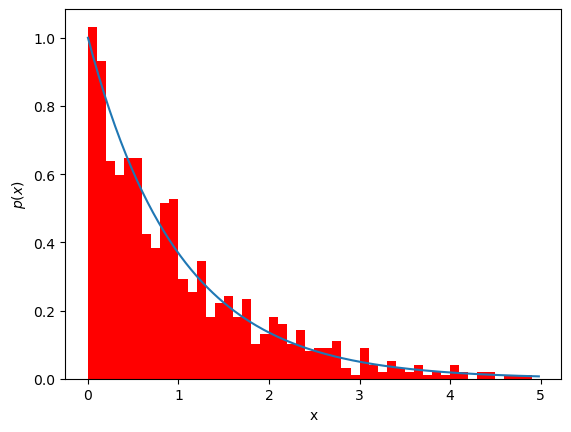

In [3]:
# Samples from an exponential distribution with rate parameter
rate=1.0
nsamp=1000
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=np.log(1.0/(1.0-usamples))/rate
xvs=np.arange(0.,5./rate,step=0.02)
histxs=np.arange(0,5./rate,step=100./(rate*nsamp))
counts,edges,patches=plt.hist(samples,bins=histxs,color="red",density=True)
plt.xlabel('x')
plt.ylabel('$p(x)$')
y=stats.expon.pdf(xvs, 0.0, 1.0/rate)
plt.plot(xvs, y)
plt.savefig("MethodOfInversionExample.pdf")

# Rejection Sampling

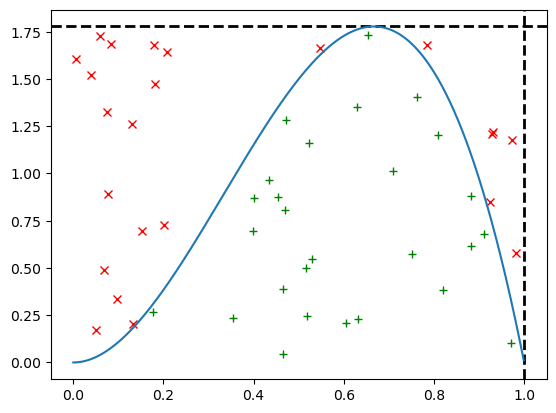

In [4]:
# We want to draw samples from a Beta(3,2) distribution using sampling in a rectangular box. The box height is M = 16/9.
nsamp=50
M=16.0/9.0
thsamples=np.random.uniform(0.0,1.0,nsamp)
ysamples=np.random.uniform(0.0,M,nsamp)

accids=ysamples < stats.beta.pdf(thsamples,3.,2.)
rejids=ysamples > stats.beta.pdf(thsamples,3.,2.)

xvs=np.arange(0.,1.,step=0.001)
pdftrue=stats.beta.pdf(xvs,3.,2.)

plt.plot(thsamples[accids],ysamples[accids],'g+')
plt.plot(thsamples[rejids],ysamples[rejids],'rx')
plt.axhline(M, color='black', lw=2, linestyle='--',label='max')
plt.axvline(1, color='black', lw=2, linestyle='--',label='')
plt.plot(xvs, pdftrue)

plt.savefig("RejectionSamplingBoxExample.pdf")

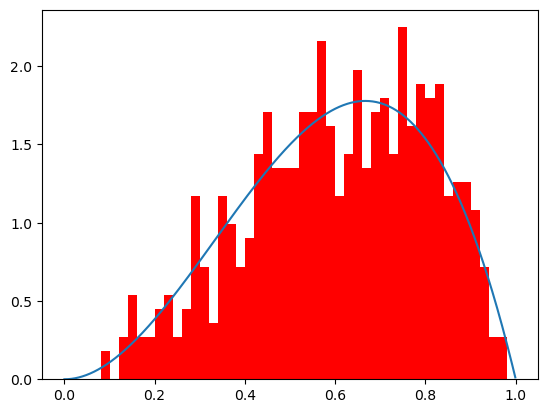

In [5]:
# Now generate more samples and check that we get the right distribution
nsamp=1000
thsamples=np.random.uniform(0.0,1.0,nsamp)
ysamples=np.random.uniform(0.0,M,nsamp)

accids=ysamples < stats.beta.pdf(thsamples,3.,2.)
rejids=ysamples > stats.beta.pdf(thsamples,3.,2.)
accepted=thsamples[accids]

histxs=np.arange(0,1.,step=0.02)
counts,edges,patches=plt.hist(accepted,bins=histxs,color="red",density=True)
plt.plot(xvs, pdftrue)

plt.savefig("RejectionSamplingBoxExample_Histogram.pdf")

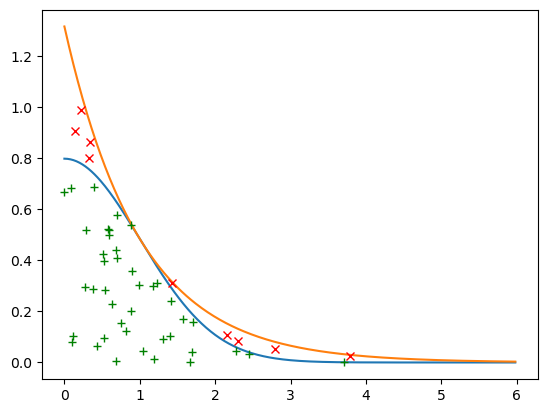

In [6]:
# We want to draw samples from a half-Normal distribution. Instead we draw samples from an expoential distribution
# with parameter 1. We set the scaling M = sqrt(2/pi)*exp(0.5) (EXERCISE).

# First compare half-Normal distribution to M g(theta)
xvs=np.arange(0.,6.,step=0.02)
M=np.sqrt(2/np.pi)*np.exp(0.5)
yhalfnorm=2.0*stats.norm.pdf(xvs,0.,1.)
yexponential=M*stats.expon.pdf(xvs, 0.0, 1.0)
plt.plot(xvs, yhalfnorm)
plt.plot(xvs,yexponential)

# Now draw samples from exponential distribution using method of inversion 
nsamp=50
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=np.log(1.0/(1.0-usamples))

# Identify accepted and rejected samples
vsamples=np.random.uniform(0.0,1.0,nsamp)
accids=vsamples < 2.0*stats.norm.pdf(samples,0.,1.)/(M*stats.expon.pdf(samples))
rejids=vsamples > 2.0*stats.norm.pdf(samples,0.,1.)/(M*stats.expon.pdf(samples))
accepted=samples[accids]
rejected=samples[rejids]

accy=M*stats.expon.pdf(samples[accids])*vsamples[accids]
rejy=M*stats.expon.pdf(samples[rejids])*vsamples[rejids]

plt.plot(accepted,accy,'g+')
plt.plot(rejected,rejy,'rx')
plt.savefig("RejectionSamplingExample.pdf")


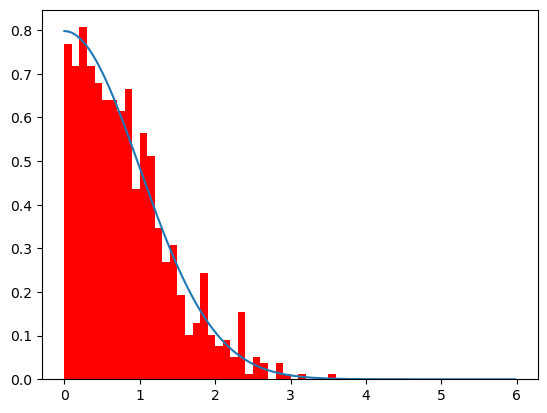

In [7]:
# Now generate 1000 samples and plot histogram
nsamp=1000
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=np.log(1.0/(1.0-usamples))

# Identify accepted and rejected samples
vsamples=np.random.uniform(0.0,1.0,nsamp)
accids=vsamples < 2.0*stats.norm.pdf(samples,0.,1.)/(M*stats.expon.pdf(samples))
accepted=samples[accids]

histxs=np.arange(0,6.,step=0.1)
counts,edges,patches=plt.hist(accepted,bins=histxs,color="red",density=True)
plt.plot(xvs, yhalfnorm)

plt.savefig("RejectionSamplingExample_Histogram.pdf")

# Importance Sampling

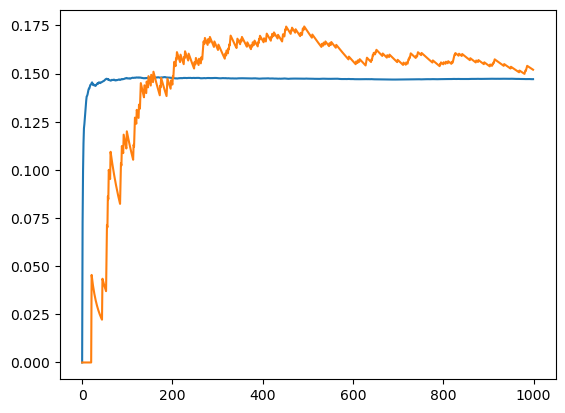

In [8]:
# Generate samples iusing g(x)=2/x^2 for x > 2
nsamp=1000
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=2.0/usamples

# Compute importance weights
weights=samples**2/(2.0*np.pi*(1.0+samples**2))

# Compute running average of weight above 2
ImpRunav=np.zeros(nsamp)
for i in range(nsamp):
    ImpRunav[i]=sum(weights[0:i])/(i+1.0)
xvs=np.arange(0,nsamp,1)
plt.plot(xvs,ImpRunav)

# Directly sample from Cauchy distribution and produce same running average
directsamples=np.random.standard_cauchy(nsamp)
DirRunav=np.zeros(nsamp)
for i in range(nsamp):
    thisset=directsamples[0:i]
    DirRunav[i]=len(thisset[thisset>2.0])/(i+1.0)
plt.plot(xvs,DirRunav)
plt.savefig("ImportanceSamplingExample.pdf")

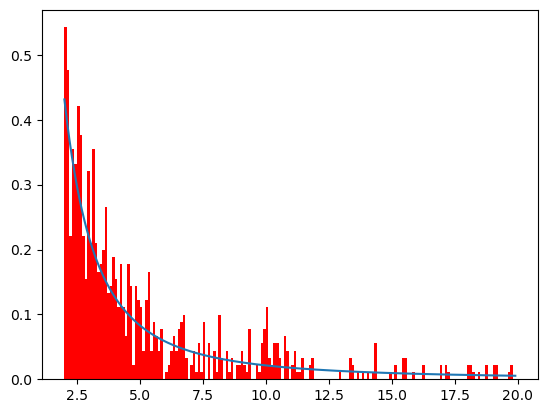

In [9]:
normweights=weights/sum(weights)
resample=np.random.choice(samples,nsamp,p=normweights)
histxs=np.arange(2.0,20.,step=0.1)
counts,edges,patches=plt.hist(resample,bins=histxs,color="red",density=True)
yvs=stats.cauchy.pdf(histxs,0.,1.)/(1.-stats.cauchy.cdf(2.0,0.,1.))
plt.plot(histxs,yvs)
plt.savefig("SIRExample.pdf")

# Model sampling with pymc

In [10]:
# Now we give an example of Bayesian posterior sampling using pymc. First we need some data. Here we will use the
# mtcars data set that we used i lectures. It is deifned in the mtcars_proc.csv data set you can download from the
# course website. 

In [11]:
datatable = np.genfromtxt("mtcars_proc.csv",names=True,delimiter=",")

In [12]:
print(datatable['mpg'])

[21.  21.  22.8 21.4 18.7 18.1 14.3 24.4 22.8 19.2 17.8 16.4 17.3 15.2
 10.4 10.4 14.7 32.4 30.4 33.9 21.5 15.5 15.2 13.3 19.2 27.3 26.  30.4
 15.8 19.7 15.  21.4]


In [13]:
basic_model = pm.Model()

mu0=0.
var0=1000.
a=0.1
b=0.1

with basic_model:

    # Priors for unknown model parameters
    beta = pm.Normal("beta", mu=mu0, sigma=np.sqrt(var0), shape=4)
    var = pm.InverseGamma("var", alpha=a, beta=b)

    # Expected value of outcome
    mu = beta[0] + beta[1] * datatable['drat'] + beta[2] * datatable['wt'] + beta[3] * datatable['qsec']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=np.sqrt(var), observed=datatable['mpg'])

In [14]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, var]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


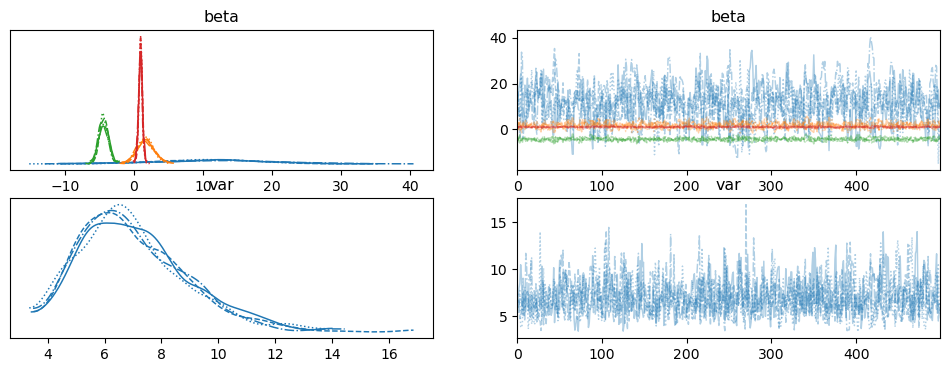

In [15]:
with basic_model:
    az.plot_trace(trace);

In [16]:
with basic_model:
    display(az.summary(trace, round_to=2))

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]  11.20  8.09   -4.17    26.31       0.34     0.25    584.08    633.89   
beta[1]   1.68  1.22   -0.38     4.24       0.05     0.03    706.02   1071.41   
beta[2]  -4.40  0.68   -5.60    -3.09       0.03     0.02    671.15    931.10   
beta[3]   0.95  0.27    0.41     1.44       0.01     0.01    893.23    877.31   
var       7.01  1.89    3.87    10.60       0.06     0.04   1087.96   1073.59   

         r_hat  
beta[0]   1.01  
beta[1]   1.00  
beta[2]   1.01  
beta[3]   1.00  
var       1.00

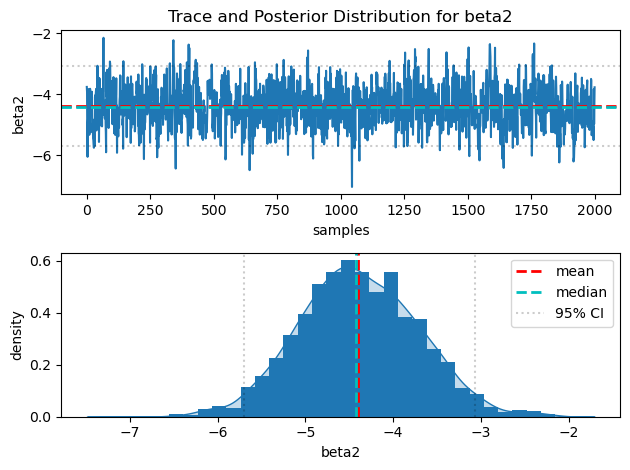

In [19]:
# Extract samples from fit for easier manipulation
#summary_dict = lin_model_fit.summary()
#lin_model_fit_dataframe = pd.DataFrame(summary_dict['summary'], 
#                  columns=summary_dict['summary_colnames'], 
#                  index=summary_dict['summary_rownames'])

# Plot trace plot and histogram of posterior samples for parameter 'param'
param='beta2'
plotdata=np.array((az.extract(trace['posterior']['beta'])).to_dataarray())[0,2,:]

cred_min, cred_max = np.percentile(plotdata, 2.5), np.percentile(plotdata, 97.5)
mean=np.mean(plotdata)
median=np.median(plotdata)

plt.subplot(2,1,1)
plt.plot(plotdata)
plt.xlabel('samples')
plt.ylabel(param)
plt.axhline(mean, color='r', lw=2, linestyle='--')
plt.axhline(median, color='c', lw=2, linestyle='--')
plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
plt.title('Trace and Posterior Distribution for {}'.format(param))

plt.subplot(2,1,2)
plt.hist(plotdata, 30, density=True); sns.kdeplot(plotdata, fill=True)
plt.xlabel(param)
plt.ylabel('density')
plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
plt.gcf().tight_layout()
plt.legend()



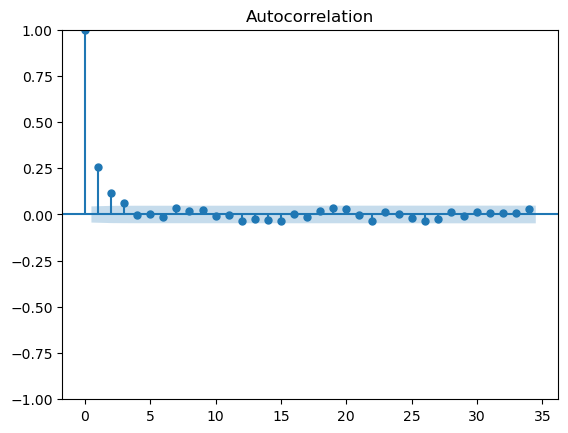

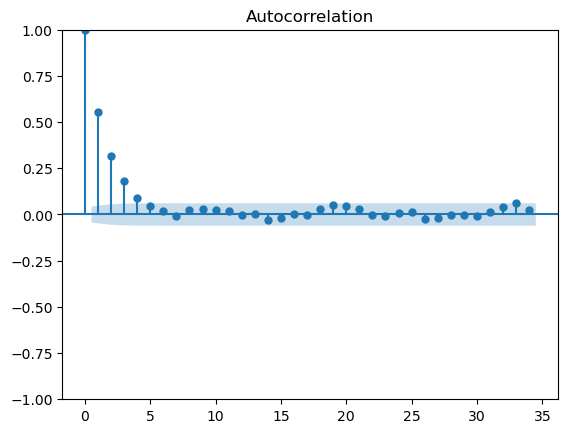

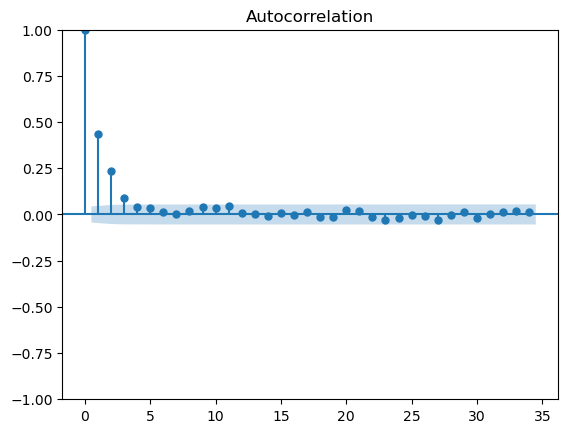

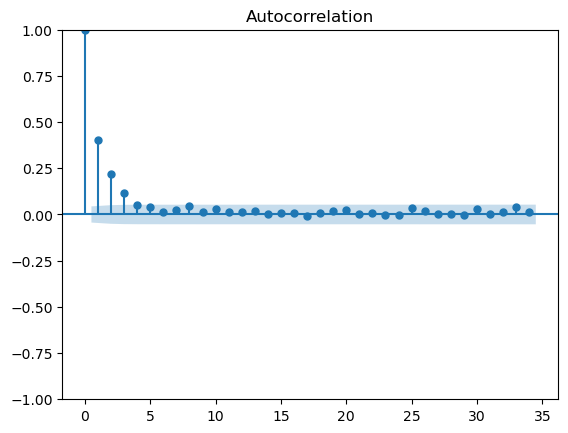

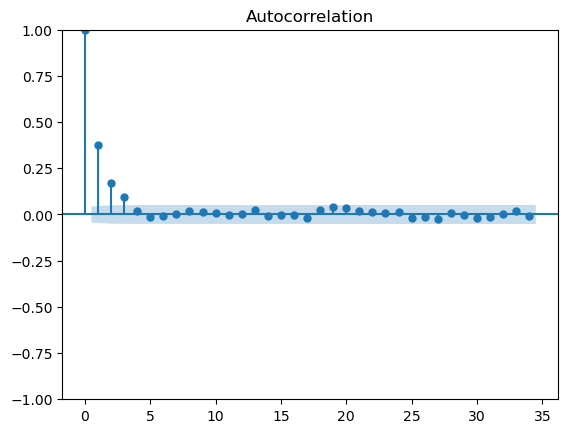

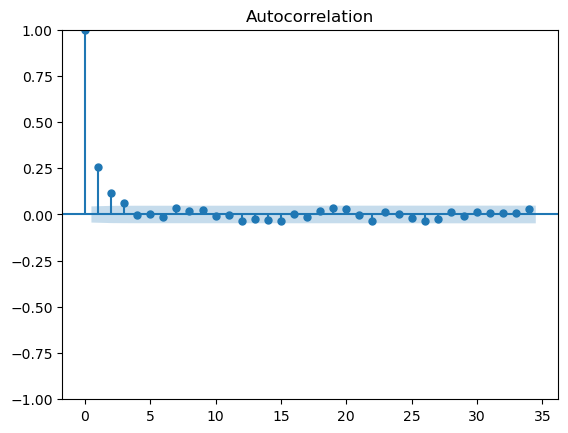

In [21]:
# Evaluate autocorrelation function
plot_acf(np.array((az.extract(trace['posterior']['beta'])).to_dataarray())[0,0,:])
plot_acf(np.array((az.extract(trace['posterior']['beta'])).to_dataarray())[0,1,:])
plot_acf(np.array((az.extract(trace['posterior']['beta'])).to_dataarray())[0,2,:])
plot_acf(np.array((az.extract(trace['posterior']['beta'])).to_dataarray())[0,3,:])
plot_acf(np.array((az.extract(trace['posterior']['var'])).to_dataarray())[0,:])

In [22]:
# A standard approach to checking the performance of a linear model fit is to compute "Studentised residuals".
# First we compute the fitted values at each point for each iteration of the chain.
plotdata=np.array((az.extract(trace['posterior']['beta'])).to_dataarray())[0,:,:]
plotdata_var=np.array((az.extract(trace['posterior']['var'])).to_dataarray())[0,:]

fittedvalues=np.empty((len(plotdata[0,:]),len(datatable['drat'])))
for i in range(len(plotdata[0,:])):
    fittedvalues[i,]=plotdata[0,i]+plotdata[1,i]*datatable['drat']+plotdata[2,i]*datatable['wt']+plotdata[3,i]*datatable['qsec']

# Now we compute the variance matrix for the estimates
XT=np.array(np.concatenate(([np.ones(len(datatable['drat']))],[datatable['drat']],[datatable['wt']],[datatable['qsec']])))
X=XT.transpose()
H=(X @ inv(XT @ X))@XT

# Compute studentised residuals
studentres=np.empty((len(plotdata[0,]),len(datatable['drat'])))
for i in range(len(plotdata[0,])):
    studentres[i,]=(datatable['mpg']-fittedvalues[i,])/(np.sqrt((plotdata_var[i])*(1-np.diagonal(H))))

# Compute mean over posterior of studentised residuial at each data point
studentisedresm=np.empty(len(datatable['mpg']))
fittedvaluesm=np.empty(len(datatable['mpg']))

for i in range(len(datatable['mpg'])):
    studentisedresm[i]=np.mean(studentres[:,i])
    fittedvaluesm[i]=np.mean(fittedvalues[:,i])

((array([-2.02511189, -1.62590278, -1.38593914, -1.20666642, -1.05953591,
         -0.93235918, -0.81872017, -0.71478609, -0.6180591 , -0.52680137,
         -0.43973827, -0.35589149, -0.27447843, -0.19484777, -0.11643566,
         -0.03873405,  0.03873405,  0.11643566,  0.19484777,  0.27447843,
          0.35589149,  0.43973827,  0.52680137,  0.6180591 ,  0.71478609,
          0.81872017,  0.93235918,  1.05953591,  1.20666642,  1.38593914,
          1.62590278,  2.02511189]),
  array([-1.69557938, -1.39536727, -1.16939314, -1.08019644, -1.05193452,
         -0.96837002, -0.89237532, -0.82299025, -0.7891807 , -0.69515626,
         -0.68361169, -0.40538905, -0.37701501, -0.36768098, -0.16090427,
         -0.13845119, -0.11139852, -0.0804214 ,  0.0930878 ,  0.15696385,
          0.22230635,  0.25634607,  0.34630817,  0.44041287,  0.44587847,
          0.53761665,  0.7917248 ,  1.39069864,  1.47949182,  1.94815084,
          2.19920535,  2.21011711])),
 (1.0297567821815463, -0.011472081875

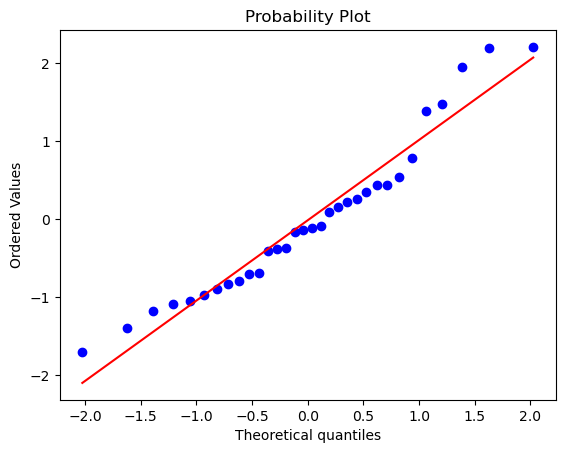

In [23]:
# Produce QQ plot. We are looking for this to be a diagonal line
stats.probplot(studentisedresm,plot=plt)

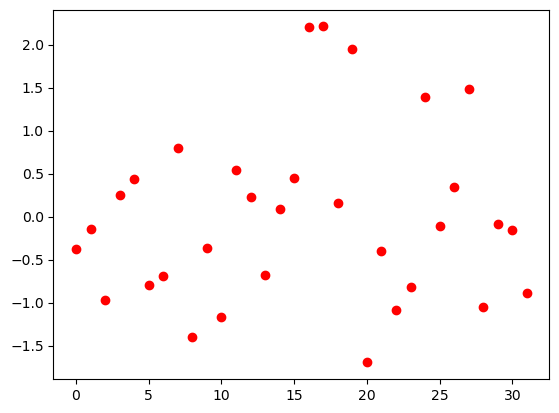

In [24]:
# Plot residuals versus index. These values should be not too farfrom zero and show no trends.
plt.plot(studentisedresm,'ro')

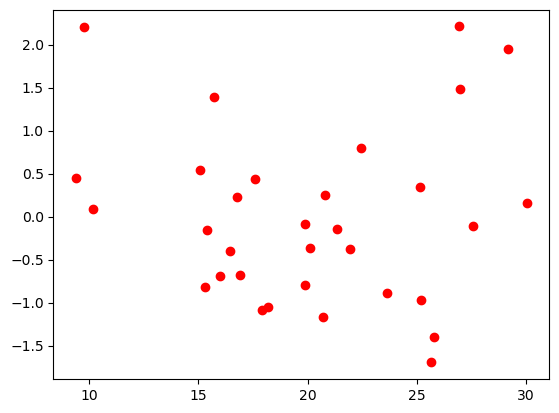

In [25]:
# Plot residuals versus fitted value. Again we are looking for the absence of trends
plt.plot(fittedvaluesm,studentisedresm,'ro')

In [26]:
with basic_model:
    posterior_pred = pm.sample_posterior_predictive(trace)

Sampling: [Y_obs]


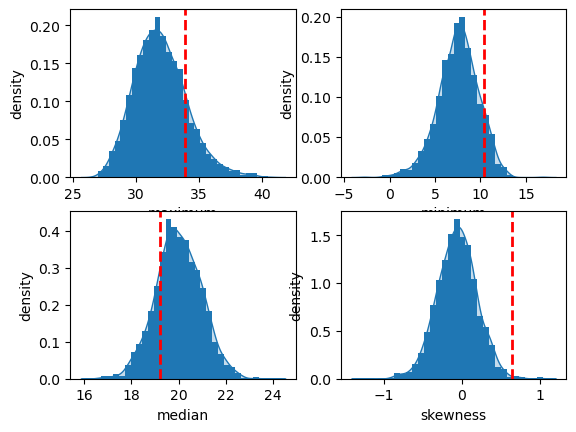

In [28]:
# Do predictive checks
preddist=np.array((az.extract(posterior_pred['posterior_predictive']['Y_obs'])).to_dataarray())[0,:,:]
maxdist=np.amax(preddist,axis=0)
mindist=np.amin(preddist,axis=0)
mediandist=np.median(preddist,axis=0)
skewdist=stats.skew(preddist,axis=0)

plt.subplot(2,2,1)
plt.hist(maxdist, 30, density=True); sns.kdeplot(maxdist, fill=True)
plt.xlabel('maximum')
plt.ylabel('density')
plt.axvline(np.amax(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,2)
plt.hist(mindist, 30, density=True); sns.kdeplot(mindist, fill=True)
plt.xlabel('minimum')
plt.ylabel('density')
plt.axvline(np.amin(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,3)
plt.hist(mediandist, 30, density=True); sns.kdeplot(mediandist, fill=True)
plt.xlabel('median')
plt.ylabel('density')
plt.axvline(np.median(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,4)
plt.hist(skewdist, 30, density=True); sns.kdeplot(skewdist, fill=True)
plt.xlabel('skewness')
plt.ylabel('density')
plt.axvline(stats.skew(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

In [29]:
robust_model = pm.Model()

mu0=0.
var0=1000.
a=0.1
b=0.1
c=0.1
d=0.1


with robust_model:

    # Priors for unknown model parameters
    beta = pm.Normal("beta", mu=mu0, sigma=np.sqrt(var0), shape=4)
    var = pm.InverseGamma("var", alpha=a, beta=b)
    nu = pm.Gamma("nu", alpha=c, beta=d)

    # Expected value of outcome
    mu = beta[0] + beta[1] * datatable['drat'] + beta[2] * datatable['wt'] + beta[3] * datatable['qsec']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT("Y_obs", nu=nu, mu=mu, sigma=np.sqrt(var), observed=datatable['mpg'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, var, nu]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]  11.41  8.25   -2.70    28.01       0.27     0.19    950.04   1583.36   
beta[1]   1.54  1.19   -0.62     3.88       0.04     0.03   1081.52   1980.21   
beta[2]  -4.39  0.73   -5.69    -2.97       0.02     0.02   1096.07   2018.02   
beta[3]   0.95  0.27    0.46     1.47       0.01     0.00   1873.40   1699.54   
var       5.06  2.00    1.60     8.52       0.05     0.03   1703.14   1465.27   
nu        7.90  6.88    1.01    20.03       0.16     0.11   1755.27   2079.80   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
beta[2]    1.0  
beta[3]    1.0  
var        1.0  
nu         1.0

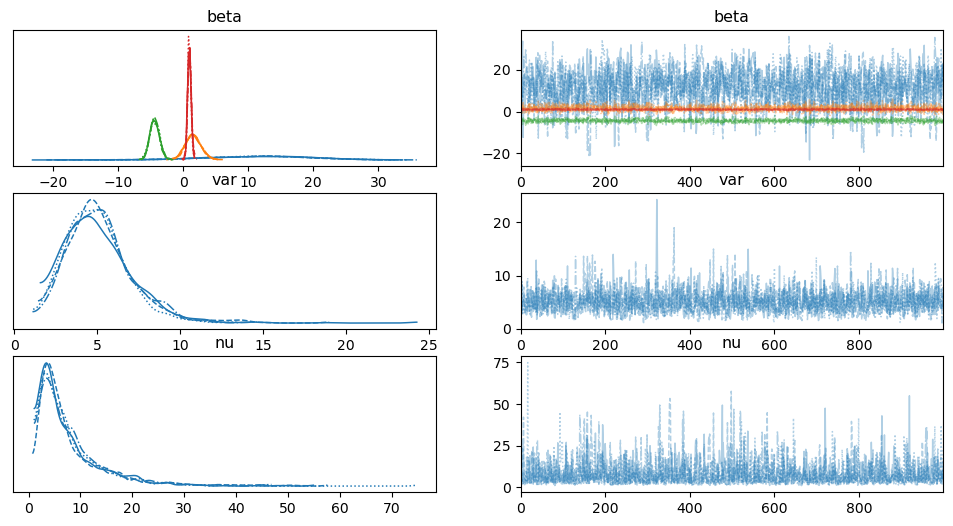

In [30]:
with robust_model:
    # draw 1000 posterior samples
    trace_robust = pm.sample(draws=1000, tune=2000, return_inferencedata=True)
with robust_model:
    az.plot_trace(trace_robust);
with robust_model:
    display(az.summary(trace_robust, round_to=2))

In [37]:
with robust_model:
    posterior_pred = pm.sample_posterior_predictive(trace_robust)

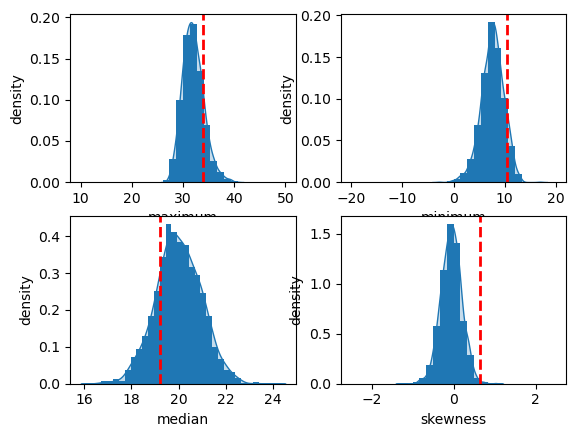

In [32]:
# Do predictive checks for the robust model
preddist=np.array((az.extract(posterior_pred['posterior_predictive']['Y_obs'])).to_dataarray())[0,:,:]
maxdist=np.amax(preddist,axis=0)
mindist=np.amin(preddist,axis=0)
mediandist=np.median(preddist,axis=0)
skewdist=stats.skew(preddist,axis=0)

plt.subplot(2,2,1)
plt.hist(maxdist, 30, density=True,range=(10,50)); sns.kdeplot(maxdist, fill=True,clip=(10,50))
plt.xlabel('maximum')
plt.ylabel('density')
plt.axvline(np.amax(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,2)
plt.hist(mindist, 30, density=True,range=(-20,20)); sns.kdeplot(mindist, fill=True,clip=(-20,20))
plt.xlabel('minimum')
plt.ylabel('density')
plt.axvline(np.amin(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,3)
plt.hist(mediandist, 30, density=True); sns.kdeplot(mediandist, fill=True)
plt.xlabel('median')
plt.ylabel('density')
plt.axvline(np.median(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

plt.subplot(2,2,4)
plt.hist(skewdist, 30, density=True,range=(-2.5,2.5)); sns.kdeplot(skewdist, fill=True,clip=(-2.5,2.5))
plt.xlabel('skewness')
plt.ylabel('density')
plt.axvline(stats.skew(datatable['mpg']), color='r', lw=2, linestyle='--',label='Observed value')

# Exercises - Solutions

In [33]:
# Here are some questions for you to answer using the techniques introduced above.

# Question 1

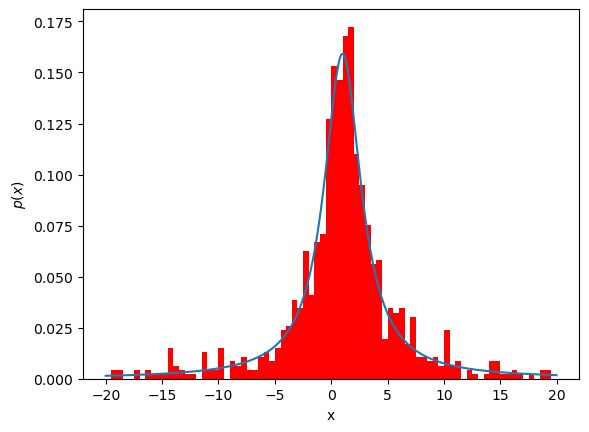

In [3]:
# Q1: Use the method of inversion to draw samples from the Cauchy distribution with location parameter
#     x0 = 1 and scale parameter gamma = 2.
# 
# The CDF of a Cauchy distribution is F(x) = 1/2 + tan^(-1)[(x-x0)/gamma]/pi, with inverse
# F^(-1)(u) = x0 + gamma*tan(pi*(u-0.5)).

x0=1.0
gamma=2.0
nsamp=1000
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=x0+gamma*np.tan(np.pi*(usamples-0.5))
xvs=np.arange(-20.,20.,step=0.02)
histxs=np.arange(-20.,20.,step=0.5)
counts,edges,patches=plt.hist(samples,bins=histxs,color="red",density=True)
plt.xlabel('x')
plt.ylabel('$p(x)$')
y=stats.cauchy.pdf(xvs, x0, gamma)
plt.plot(xvs, y)


# Question 2

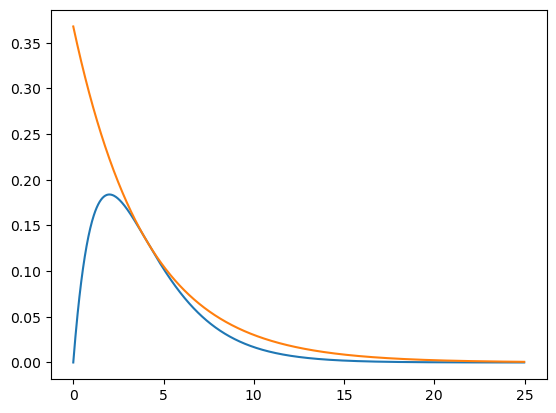

In [4]:
# Q2: Draw samples from a Gamma(2,0.5) distribution using rejection sampling. Start by using an Exp(0.25)
#     distribution as the sampling distribution. In that case you should set M = 4/e = 1.4715 (prove this!).
#     Can you make the algorithm more efficient by using a different rate parameter?

# First we check the choice of M
rate=0.25
xvs=np.arange(0.,25.,step=0.02)
M=4.0/np.exp(1.0)
ygamma=stats.gamma.pdf(xvs,2.,0.,2.0)
yexponential=M*stats.expon.pdf(xvs, 0.0, 1.0/rate)
plt.plot(xvs, ygamma)
plt.plot(xvs,yexponential)

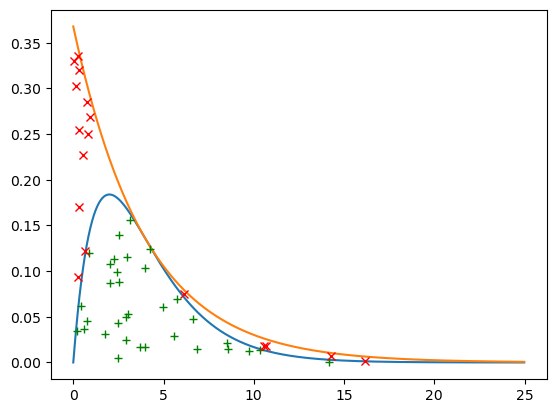

In [5]:
# Now we do rejection sampling - 50 points to check it is working
nsamp=50
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=np.log(1.0/(1.0-usamples))/rate

# Identify accepted and rejected samples
vsamples=np.random.uniform(0.0,1.0,nsamp)
accids=vsamples < stats.gamma.pdf(samples,2.,0.,2.0)/(M*stats.expon.pdf(samples,0.0, 1.0/rate))
rejids=vsamples > stats.gamma.pdf(samples,2.,0.,2.0)/(M*stats.expon.pdf(samples,0.0, 1.0/rate))
accepted=samples[accids]
rejected=samples[rejids]

accy=M*stats.expon.pdf(samples[accids],0.0, 1.0/rate)*vsamples[accids]
rejy=M*stats.expon.pdf(samples[rejids],0.0, 1.0/rate)*vsamples[rejids]

plt.plot(xvs, ygamma)
plt.plot(xvs,yexponential)
plt.plot(accepted,accy,'g+')
plt.plot(rejected,rejy,'rx')


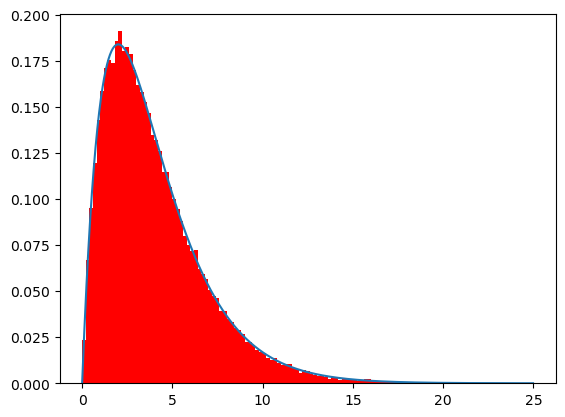

In [6]:
# Now 1000 points and generate histogram
nsamp=100000
usamples=np.random.uniform(0.0,1.0,nsamp)
samples=np.log(1.0/(1.0-usamples))/rate

# Identify accepted and rejected samples
vsamples=np.random.uniform(0.0,1.0,nsamp)
accids=vsamples < stats.gamma.pdf(samples,2.,0.,2.0)/(M*stats.expon.pdf(samples,0.0, 1.0/rate))
accepted=samples[accids]

histxs=np.arange(0,25.,step=0.2)
counts,edges,patches=plt.hist(accepted,bins=histxs,color="red",density=True)
plt.plot(xvs, ygamma)


In [38]:
# If we considered using an exponential(alpha) sampling distribution, then the optimal value of M can be found as
# 0.25 e/(alpha*(0.5-alpha)). We are most efficient if the area between the two curves is as small as possible 
# relative to the area under the target distribution. As the latter is fixed, and the area under the sampling 
# distribution is M (since it is M times a probability distribution), the most efficient algorithm is the one
# with the smallest M. We see that this has alpha = 0.25, so we can't do any better.

# Question 3

In [8]:
# Q3: Newton's law of cooling. The following data are measurements of the temperature of a bore after 
#     that bore had been rubbed inside “a stationary cylinder and pressed against the bottom by means 
#     of a screw”. The bore was turned by a team of horses (this is an experiment with friction from 
#     1798 by a Count Rumford).

elapsedtime=[4.,5.,7.,12.,14.,16.,20.,24.,28.,31.,34.,37.5,41.]
temp=[126.,125.,123.,120.,119.,118.,116.,115.,114.,113.,112.,111.,110.]

#     Newton's Law of Cooling sugests that the temperature should vary with time according to
#              temp = 60 + 70 exp(- theta * time)
#     Assuming that the errors in the observations are normally distributed with unknown variance 
#     sigma^2, use pymc to produce a Bayesian fit of this model to the data. Use an exponential prior
#     on theta since it is constrained to be positive. First fit a model in which the coefficients in
#     the model are fixed to be 60 and 70, and then try fitting a model in which these are taken to be 
#     unknown. In the latter case, again use exponential priors on the unknown coefficients.

In [9]:
# First we take 60 and 70 as fixed known quantities. The pymc model definition is

newt_cool_model = pm.Model()

lam=100.
a=0.01
b=0.01

with newt_cool_model:

    # Priors for unknown model parameters
    theta = pm.Exponential("theta", lam=lam)
    var = pm.InverseGamma("var", alpha=a, beta=b)
    
    # Expected value of outcome
    mu = 60.0 + 70.0 * np.exp(-1.0*theta*elapsedtime)
    
    # Likelihood (sampling distribution) of observations
    Temp = pm.Normal("Temp", mu=mu, sigma=np.sqrt(var), observed=temp)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, var]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
theta  0.0094  0.0004  0.0086   0.0103     0.0000   0.0000  2589.4141   
var    4.2986  2.0538  1.5473   7.9170     0.0397   0.0286  2759.7070   

        ess_tail   r_hat  
theta  2433.7915  1.0008  
var    2350.5011  1.0011

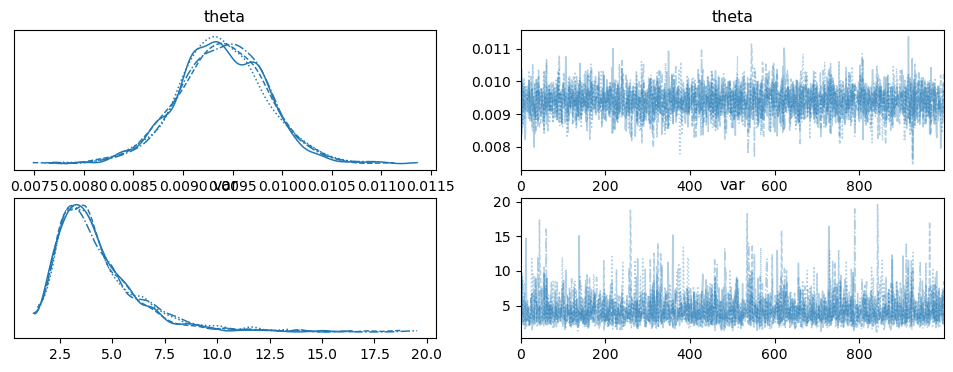

In [10]:
# Now we sample from the model
with newt_cool_model:
    # draw 1000 posterior samples
    trace_newt_cool = pm.sample(draws=1000, tune=2000, return_inferencedata=True)
with newt_cool_model:
    az.plot_trace(trace_newt_cool);
with newt_cool_model:
    display(az.summary(trace_newt_cool, round_to=4))

In [11]:
# Now we let the coefficients be unconstrained. We use exponential priors on the
# addiitonal unknown parameters, and set the scale by the expected values that 
# were used in the previous fit.
#
# The pymc model definition is

newt_cool_model_2 = pm.Model()

lam=100.
lam_beta0=1./60.0
lam_beta1=1./70.0
a=0.01
b=0.01

with newt_cool_model_2:

    # Priors for unknown model parameters
    theta = pm.Exponential("theta", lam=lam)
    beta0 = pm.Exponential("beta0", lam=lam_beta0)
    beta1 = pm.Exponential("beta1", lam=lam_beta1)
    var = pm.InverseGamma("var", alpha=a, beta=b)
    
    # Expected value of outcome
    mu = beta0 + beta1 * np.exp(-1.0*theta*elapsedtime)
    
    # Likelihood (sampling distribution) of observations
    Temp = pm.Normal("Temp", mu=mu, sigma=np.sqrt(var), observed=temp)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta0, beta1, var]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 328 divergences after tuning. Increase `target_accept` or reparameterize.


mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta    0.0385  0.0052    0.0287    0.0476     0.0004   0.0003  167.7514   
beta0  105.2800  2.2561  102.2573  107.8880     0.1790   0.1283  154.6245   
beta1   23.6211  1.9279   21.6005   25.9828     0.1511   0.1070  149.3107   
var      0.1602  0.1120    0.0461    0.3230     0.0101   0.0071   57.0989   

       ess_tail   r_hat  
theta  256.6706  1.0229  
beta0  225.3539  1.0269  
beta1  225.1796  1.0294  
var     29.4407  1.0507

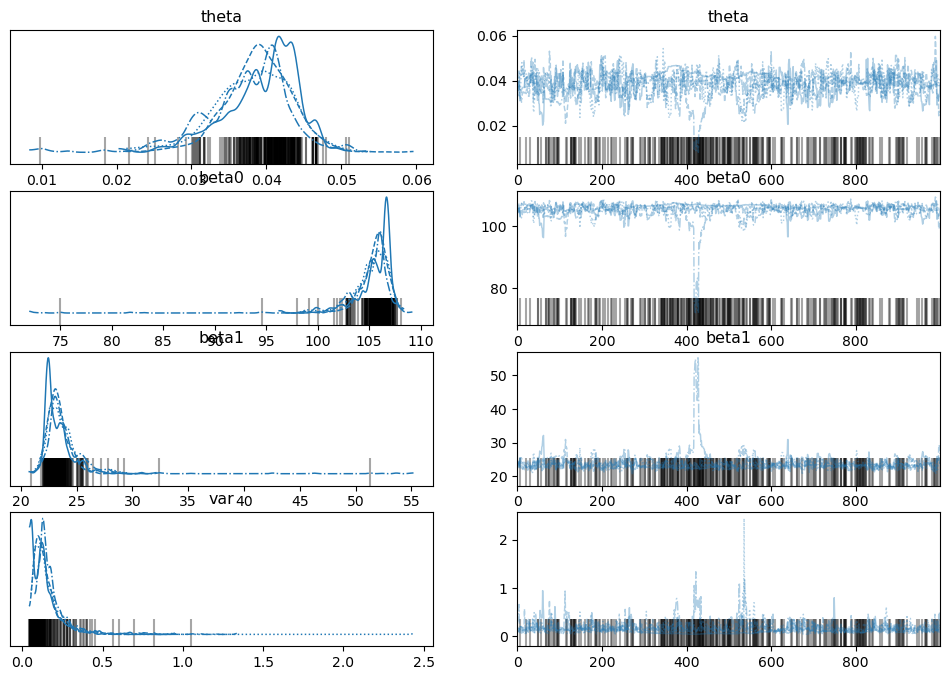

In [12]:
# Now we sample from the model
with newt_cool_model_2:
    # draw 1000 posterior samples
    trace_newt_cool_2 = pm.sample(draws=1000, tune=2000, return_inferencedata=True)
with newt_cool_model_2:
    az.plot_trace(trace_newt_cool_2);
with newt_cool_model_2:
    display(az.summary(trace_newt_cool_2, round_to=4))

# Question 4

In [13]:
# Q4: Fitting a hierarchical model. The folllowing array is a set of observations of the log-concentration
#     of a chemical, made at a total of 6 different sites. 10 observations were taken at each site and
#     obs[i,j] gives the value of the j'th observation made at the i'th site. Observations are believed
#     to be normally distributed at each site, with different means and variances at each site. Fit a 
#     hierarchical model to this data. For the population model, assume that the means in each site
#     are drawn a Normal distribution and the variances from an inverse-Gamma distribution.

obs=np.array([[13.14766547, 11.65845248, 11.56903942, 13.30017572, 12.75290711,
        12.47226573, 12.86027664, 12.77258952, 11.47253818, 10.65388717],
       [ 5.22708745,  5.14072876,  4.79116053,  6.06708102,  6.16374444,
         6.56102816,  6.76745624,  6.28072626,  6.38667077,  6.65235986],
       [10.21890044, 10.5011379 , 11.24747508, 10.53690814, 10.64255691,
        11.10674991, 12.54279537, 11.52961432, 10.87592485, 10.62922214],
       [ 1.42142063,  2.9574681 , -0.55506519,  1.84510656,  1.64785178,
         2.06180399,  0.74795293,  2.87438485,  2.14870481,  1.46281115],
       [13.85088519, 13.38392695, 13.79264416, 13.68931158, 14.26866452,
        13.95634789, 13.72123356, 14.12700254, 14.06210889, 13.88442947],
       [ 0.24305202,  3.72875987,  0.73729056,  0.95080047,  2.18295888,
         3.0240565 ,  4.24451313,  0.02679825,  4.33104446,  4.55617951]])

In [14]:
obs.shape[0]

6

In [15]:
# To fit a hierarchical model in pymc we can deifne a bespoke likelihood using the 
# DensityDist function. However, pymc fits better when the likelihood can be written
# as a combination of simple functions, since it can then sample using derivative
# based optimizers.
#
# If we want to use the pm.Normal model, we need to have a single vector of 
# observations. We construct this using the numpy reshape function.
ngroups=obs.shape[0]
nobs=obs.shape[1]
obsvec=np.reshape(obs,-1)

# We also need to define an array, X, that labels which group each observation is in. 
# If we then define a parameter vector mu, the elements of which are the individual 
# group means, then the product X * mu will return a vector, the elements of which are
# the group means for the corresponding observations.

x=np.zeros((ngroups,nobs*ngroups))
for i in range(ngroups):
    for j in range(nobs):
        x[i,nobs*i+j]=1.
        
# Note that while the observations are balanced here, so that there are equal numbers 
# of observations in each group, this approach could be used directly to fit unbalanced
# observations too.

In [16]:
# We now define the pymc model

hierarchical_model = pm.Model()

ngroups=6
nobs=10

mu0=0.
var0=1000.
a=0.01
b=0.01
c=0.01
d=0.01


with hierarchical_model:

    # Priors for unknown model parameters
    meanmu = pm.Normal("PopMean",mu=mu0,sigma=np.sqrt(var0))
    meanvar = pm.InverseGamma("PopVar",alpha=a, beta=b)
    vara = pm.Gamma("Vara",alpha=c, beta=d)
    varb = pm.Gamma("Varb",alpha=c, beta=d)
    
    mu = pm.Normal("GroupMean",mu=meanmu,sigma=np.sqrt(meanvar),shape=ngroups)
    var = pm.InverseGamma("Groupvar", alpha=vara, beta=varb, shape=ngroups)

    thismu=np.zeros_like(obsvec)
    thisvar=np.zeros_like(obsvec)
    
    # We construct the vectors thismu and thisvar, which are the same length as the
    # observation vector obsvec. The elements of these vectors are the group means
    # and variances that the individual observation belonged to. The vectors are 
    # constructed using the X matrix defined earlier.
    
    thismu=mu[0]*x[0]
    thisvar=var[0]*x[0]
    for i in range(ngroups-1):
        thismu=thismu+mu[i+1]*x[i+1]
        thisvar=thisvar+var[i+1]*x[i+1]
        
    Y_obs = pm.Normal("Y_obs", mu=thismu, sigma=np.sqrt(thisvar), observed=obsvec)
    

In [17]:
# We can verify what the code that constructs thismu and thisvar is doing here. It should
# create a vector that is a list of mean values corresponding to each group. The mu 
# vector is of length ngroups and each entry is the mean for one group. Here we create
# a fake mu vector that contains the numbers 1 to 6. The thismu vector is of length 
# equal to the number of observations, and each entry should be an index corresponding 
# to the group the observation is part of.
mu=np.arange(1,7)
thismu=mu[0]*x[0]
for i in range(ngroups-1):
    thismu=thismu+mu[i+1]*x[i+1]
print(thismu)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [PopMean, PopVar, Vara, Varb, GroupMean, Groupvar]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.


mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
PopMean        7.74    2.82    2.45    12.56       0.08     0.07   1248.23   
GroupMean[0]  12.26    0.29   11.72    12.85       0.01     0.01   1590.79   
GroupMean[1]   6.00    0.24    5.56     6.48       0.01     0.00   1612.51   
GroupMean[2]  10.97    0.23   10.51    11.36       0.01     0.00   1992.90   
GroupMean[3]   1.68    0.33    1.06     2.31       0.01     0.00   3211.11   
GroupMean[4]  13.87    0.13   13.63    14.11       0.00     0.00    991.96   
GroupMean[5]   2.46    0.58    1.29     3.50       0.01     0.01   2723.47   
PopVar        49.23  223.26    7.04   107.57       4.78     3.38   1358.28   
Vara           1.33    1.03    0.15     3.25       0.06     0.05    581.22   
Varb           0.64    0.69    0.00     1.90       0.04     0.03    624.09   
Groupvar[0]    0.84    0.43    0.30     1.57       0.01     0.01   2500.94   
Groupvar[1]    0.58    0.30    0.18     1.13       0.01     0.00   2752.96   
Groupvar[2]    0.55    0.29    0.17     1.05       0.01     0.01   2105.92   
Groupvar[3]    1.13    0.61    0.39     2.22       0.01     0.01   2445.89   
Groupvar[4]    0.17    0.12    0.03     0.39       0.00     0.00   1173.47   
Groupvar[5]    3.31    2.22    0.91     6.46       0.05     0.04   1801.27   

              ess_tail  r_hat  
PopMean         534.88   1.00  
GroupMean[0]   1067.43   1.00  
GroupMean[1]   1171.76   1.00  
GroupMean[2]   2042.50   1.00  
GroupMean[3]   2275.12   1.00  
GroupMean[4]    636.43   1.00  
GroupMean[5]   1825.54   1.00  
PopVar         1010.75   1.00  
Vara            314.83   1.01  
Varb            401.34   1.01  
Groupvar[0]    1782.79   1.00  
Groupvar[1]    1738.85   1.00  
Groupvar[2]    1417.90   1.00  
Groupvar[3]    2272.80   1.00  
Groupvar[4]    1468.20   1.00  
Groupvar[5]    1467.00   1.00

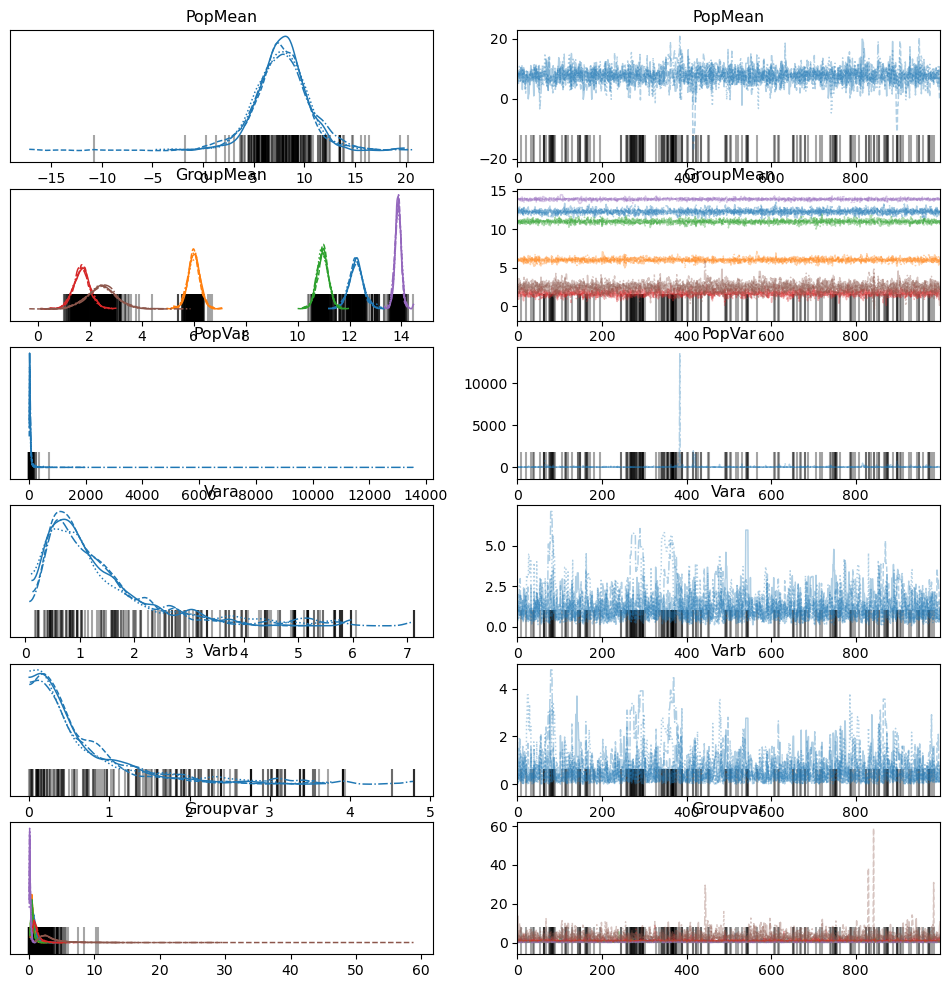

In [18]:
# Now we sample from the model
with hierarchical_model:
    # draw 1000 posterior samples
    trace_hierarchical_model = pm.sample(draws=1000, tune=2000, return_inferencedata=True)
with hierarchical_model:
    az.plot_trace(trace_hierarchical_model);
with hierarchical_model:
    display(az.summary(trace_hierarchical_model, round_to=2))

# Question 4 data generation

In [52]:
# The data for Q4 was generated as follows. We have 6 different groups, and 10 observations within each group.
# We reset the seed here for reproducibility.

np.random.seed(12)
ngroups=6
nobs=10

# Population prior for mean - normal distribution with mean 10 and variance 2

popmu=10
popvar=25

# Population prior for within group precisions (i.e., 1/variance) - Gamma()

popvara=2
popvarb=1

# Draw population properties
grpmeans=np.random.normal(popmu,np.sqrt(popvar),ngroups)
grpvars=1./(np.random.gamma(popvara,popvarb,ngroups))

print(grpmeans)
print(grpvars)

[12.36492916  6.5928706  11.21219748  1.49632183 13.76571417  2.3263933 ]
[0.59762344 0.65953412 0.99217986 0.42480221 0.28411687 1.85658192]


In [53]:
# Now generate observations in each group.
obs=np.empty((ngroups,nobs))
for i in range(ngroups):
    obs[i,]=np.random.normal(grpmeans[i],np.sqrt(grpvars[i]),nobs)

In [54]:
obs

array([[13.14766547, 11.65845248, 11.56903942, 13.30017572, 12.75290711,
        12.47226573, 12.86027664, 12.77258952, 11.47253818, 10.65388717],
       [ 5.22708745,  5.14072876,  4.79116053,  6.06708102,  6.16374444,
         6.56102816,  6.76745624,  6.28072626,  6.38667077,  6.65235986],
       [10.21890044, 10.5011379 , 11.24747508, 10.53690814, 10.64255691,
        11.10674991, 12.54279537, 11.52961432, 10.87592485, 10.62922214],
       [ 1.42142063,  2.9574681 , -0.55506519,  1.84510656,  1.64785178,
         2.06180399,  0.74795293,  2.87438485,  2.14870481,  1.46281115],
       [13.85088519, 13.38392695, 13.79264416, 13.68931158, 14.26866452,
        13.95634789, 13.72123356, 14.12700254, 14.06210889, 13.88442947],
       [ 0.24305202,  3.72875987,  0.73729056,  0.95080047,  2.18295888,
         3.0240565 ,  4.24451313,  0.02679825,  4.33104446,  4.55617951]])